# Loading LID Artifacts

In [25]:
import notebook_setup


artifact_path = 'YOUR_PATH'
artifact_subpath = {
    'mnist': {
        '1': 'd231eafb0dc04b8bb7b7e1277a4ee5c2',
        '50': '76b2894022a548968fae49dd0724a34a',
        'deterministic': None,
    },
    'fmnist': {
        '1': 'e33c3ac2c31e4fd3bb8f45387f3278fb',
        '50': '04de0cf92be54dea91b078f22c9bf5a0',
        'deterministic': '7efd34bea2bb449ea491fc349022123e',
    },
    'svhn': {
        '1': 'ff1d91e54c86414b8a73d14af1fe9c4b',
        '50': 'f5c7beca057e41599e282eac46d68d05',
        'deterministic': '2f83ed0aa9364e10aacd93e2e65b0608',
    },
    'cifar10': {
        '1': 'c698d6a3754e4562ad9326a1d6606253',
        '50': 'd82aeec5c4044d85ba51a1e9e38a367c',
        'deterministic': '6875a0dd4cda4c6cbcfbbebf2c4fb67e',
    },
}

Set up your .env to contain `<DATASET>_EXP_HUTCH_<HUTCH_SAMPLES>_ROOT` variables pointing to the artifacts directories for your mnist, fmnist, svhn, and cifar10 experiments for hutch sample settings 1, 50, and "deterministic."

In [ ]:
from pathlib import Path


def get_trend_df(dataset, hutch):
    artifact_dir = Path(artifact_path.format(subpath=artifact_subpath[dataset][hutch]))
    lid_trend_path = artifact_dir / 'lid_logs_FPKRapidEstimator/trends/trend_epoch=0001.csv'
    if not lid_trend_path.exists():
        lid_trend_path = artifact_dir / 'FPKRapidEstimator/trends/trend_epoch=0001.csv'

    return pd.read_csv(lid_trend_path)


trend_df = {
    dataset: {
        hutch: get_trend_df(dataset, hutch) 
        for hutch, subpath in hyper_paths.items() if subpath is not None
    } for dataset, hyper_paths in artifact_subpath.items()
}

# Analyzing Hutchinson Sample Count
Here we look at LID predictions by number of Hutchinson samples. We conclude
1. that 1 Hutchinson sample is enough for small timesteps, but for larger timesteps it is a poor estimate, and
2. 50 Hutchinson samples is a sufficient estimate for the actual trace in this context.

Create a dataframe for each dataset and timestep pair to compare Hutchinson sample counts

In [29]:
hutch_comparison_df = {
    dataset: {
        timestep: pd.DataFrame.from_dict({
            f'{hutch_samples}': trend_df[dataset][hutch_samples][str(timestep)] 
            for hutch_samples in ('1', '50', 'deterministic')
        })
        for timestep in range(100)
    } for dataset in ('fmnist', 'svhn', 'cifar10')
}

hutch_comparison_df['cifar10'][2]

,1,50,deterministic
0,107.845215,29.971924,51.446260
1,689.048460,808.751100,825.415600
2,730.761100,749.949500,761.267460
3,59.145140,-28.207336,-17.576172
4,610.927800,680.136700,721.978700
...,...,...,...
123,-190.723570,0.294434,10.490356
124,-48.432740,-84.382706,-58.309708
125,522.043330,607.261100,632.983640
126,213.447170,218.734010,247.332030


### Graphical comparison

What is the relationship between Hutchinson trace estimates and the actual trace?

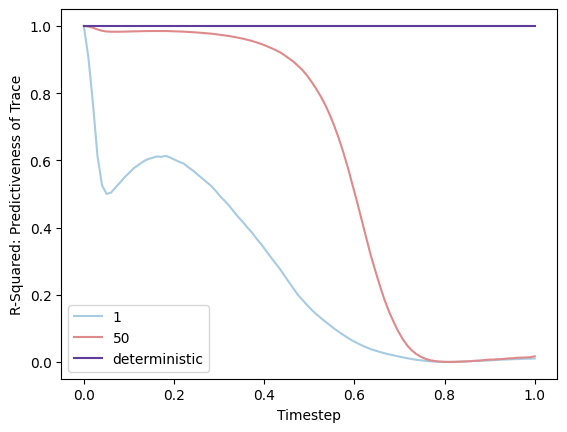

In [53]:
import matplotlib.pyplot as plt
import statsmodels.api as sm


dataset = 'svhn'
def regress_deterministic_on_num_samples(dataset, timestep, hutch_samples):
    y = hutch_comparison_df[dataset][timestep]['deterministic']
    X = hutch_comparison_df[dataset][timestep][hutch_samples]
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X)
    results = model.fit()
    return results


colors = ColorTheme.get_colors(3)

for idx, hutch_samples in enumerate(('1', '50', 'deterministic')):
    plt.plot(
        np.linspace(1e-4, 1, 100), 
        [regress_deterministic_on_num_samples(dataset, timestep, hutch_samples).rsquared 
         for timestep in range(100)], 
        label=hutch_samples, 
        color=colors[idx]
    )

plt.xlabel('Timestep')
plt.ylabel('R-Squared: Predictiveness of Trace')
plt.legend()

How about the rank ordering?

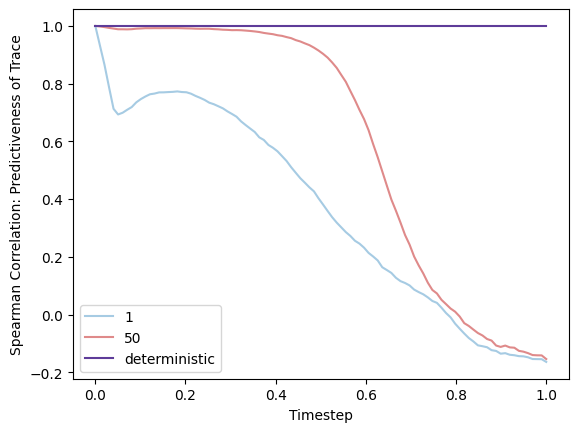

In [51]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr

from visualization.pretty import ColorTheme


def spearman_correlation_deterministic_vs_num_samples(dataset, timestep, hutch_samples):
    y = hutch_comparison_df[dataset][timestep]['deterministic']
    X = hutch_comparison_df[dataset][timestep][hutch_samples]
    correlation, p_value = spearmanr(X, y)
    return correlation


colors = ColorTheme.get_colors(3)

for idx, hutch_samples in enumerate(('1', '50', 'deterministic')):
    plt.plot(
        np.linspace(1e-4, 1, 100), 
        [spearman_correlation_deterministic_vs_num_samples(dataset, timestep, hutch_samples) 
         for timestep in range(100)], 
        label=hutch_samples, 
        color=colors[idx]
    )

plt.xlabel('Timestep')
plt.ylabel('Spearman Correlation: Predictiveness of Trace')
plt.legend()